In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

*ktrain* currently uses the CRF module from `keras_contrib`, which is not yet fully compatible with TensorFlow 2.
To use the BiLSTM-CRF model (which currently requires `keras_contrib`) for sequence-tagging in *ktrain*, you must disable V2 behavior in  TensorFlow 2
by adding the following line to the top of your notebook or script **before** importing *ktrain*. (By contrast, the BiLSTM model (with no CRF layer) can be used with TensorFlow 2 as is.)

In [2]:
os.environ['DISABLE_V2_BEHAVIOR'] = '1'

In [3]:
import ktrain
from ktrain import text

Using DISABLE_V2_BEHAVIOR with TensorFlow


W0317 17:22:19.323261 140063630042944 file_utils.py:38] Deprecated cache directory found (/home/amaiya/.allennlp/datasets).  Please remove this directory from your system to free up space.


# Sequence Tagging

Sequence tagging (or sequence labeling) involves classifying words or sequences of words as representing some category or concept of interest.  One example of sequence tagging is Named Entity Recognition (NER), where we classify words or sequences of words that identify some entity such as a person, organization, or location.  In this tutorial, we will show how to use *ktrain* to perform sequence tagging in three simple steps.

## STEP 1: Load and Preprocess Data

The `entities_from_txt` function can be used to load tagged sentences from a text file.  The text file can be in one of two different formats: 1) the [CoNLL2003 format](https://www.aclweb.org/anthology/W03-0419) or 2) the [Groningen Meaning Bank (GMB) format](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). In both formats, there is one word and its associated tag on each line (where the word and tag are delimited by a space, tab or comma).  Words are ordered as they appear in the sentence.  In the CoNLL2003 format, there is a blank line that delineates sentences.  In the GMB format, there is a third column for Sentence ID that assignes a number to each row indicating the sentence to which the word belongs.  If you are building a sequence tagger for your own use case with the `entities_from_txt` function, the training data should be formatted into one of these two formats. Alternatively, one can use the `entities_from_aray` function which simply expects arrays of the following form:
```python
x_train = [['Hello', 'world', '!'], ['Hello', 'Barack', 'Obama'], ['I', 'love', 'Chicago']]
y_train = [['O', 'O', 'O'], ['O', 'B-PER', 'I-PER'], ['O', 'O', 'B-LOC']]
```
Note that the tags in this example follow the [IOB2 format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).

In this notebook, we will be using `entities_from_txt`  and build a sequence tagger using the Groningen Meaning Bank NER dataset available on Kaggle [here](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). The format essentially looks like this (with fields being delimited by comma):
```
      SentenceID   Word     Tag    
      1            Paul     B-PER
      1            Newman   I-PER
      1            is       O
      1            a        O
      1            great    O
      1            actor    O
      1            .        O
 ```

We will be using the file `ner_dataset.csv` (which conforms to the format above) and will load and preprocess it using the `entities_from_txt` function.  The output is simlar to data-loading functions used in previous tutorials and includes the processed training set, processed validaton set, and an instance of `NERPreprocessor`.  

The Kaggle dataset `ner_dataset.csv` the three columns of interest (mentioned above) are labeled 'Sentence #', 'Word', and 'Tag'.  Thus, we specify these in the call to the function.

In [4]:
DATAFILE = '/home/amaiya/data/groningen_meaning_bank/ner_dataset.csv'
WV_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
(trn, val, preproc) = text.entities_from_txt(DATAFILE,
                                             wv_path_or_url=WV_URL,
                                             sentence_column='Sentence #',
                                             word_column='Word',
                                             tag_column='Tag', 
                                             data_format='gmb')

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-org', 'I-org', 'B-tim', 'I-art', 'I-eve', 'B-art', 'I-nat', 'B-nat', 'B-gpe', 'I-gpe', 'I-per', 'I-geo', 'B-eve', 'I-tim', 'O', 'B-geo', 'B-per']
Number of Labels:  17
Longest sentence: 104 words


In the cell above, notice that we suppied the `wv_path_or_url` argument.  This directs *ktrain* to employ one of the pretrained fasttext (word2vec) word vector sets from [Facebook's fastttext site](https://fasttext.cc/docs/en/crawl-vectors.html).   When supplied with a valid URL to a `.vec.gz`, the word vectors will be automatically downloaded, extracted, and loaded in STEP 2 (download location is `<home_directory>/ktrain_data`). To disable pretrained word embeddings, set `wv_path_or_url=None` and randomly initialized word embeddings will be employed. Use of pretrained embeddings will typically boost final accuracy. 
One can also supply `use_elmo=True` to utilize ELMo embeddings, but we have not done this here.

## STEP 2:  Define a Model

The `print_sequence_taggers` function shows that, as of this writing, *ktrain* currently supports both Bidirectional LSTM-CRM and Bidirectional LSTM models for sequence tagging.  

In [5]:
text.print_sequence_taggers()

bilstm-crf: Bidirectional LSTM-CRF  (https://arxiv.org/abs/1603.01360)
bilstm: Bidirectional LSTM (no CRF layer)  (https://arxiv.org/abs/1603.01360)


In [6]:
model = text.sequence_tagger('bilstm-crf', preproc) 

pretrained word embeddings will be loaded from:
	https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
loading pretrained word vectors...this may take a few moments...


In [8]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

## STEP 3: Train and Evaluate the Model

Here, we will train for a single epoch using an initial learning rate of 0.01 with gradual decay using cosine annealing (via the `cycle_len=1`) parameter and see how well we do.

In [9]:
learner.fit(1e-2, 1, cycle_len=1)

338/338 [==============================] - 120s 356ms/step - loss: 4.6252 - val_loss: 4.2747


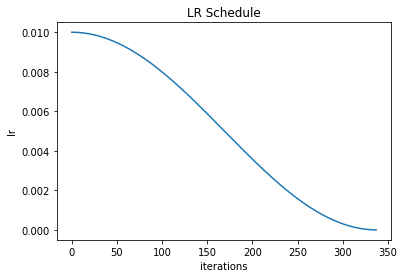

In [11]:
learner.plot('lr')

Our F1-score is **84.18** after a single pass through the dataset. Not bad for a single epoch of training.

In [12]:
learner.validate(class_names=preproc.get_classes())

   F1: 84.18
           precision    recall  f1-score   support

      geo       0.85      0.91      0.88      3631
      gpe       0.97      0.93      0.95      1537
      per       0.80      0.79      0.79      1720
      tim       0.88      0.85      0.86      1992
      org       0.75      0.69      0.72      1953
      art       0.00      0.00      0.00        35
      nat       1.00      0.21      0.34        24
      eve       0.62      0.19      0.29        27

micro avg       0.85      0.84      0.84     10919
macro avg       0.84      0.84      0.84     10919



0.8417564208782105

Let's invoke `view_top_losses` to see the sentence we got the most wrong. This single sentence about James Brown contains 10 words that are misclassified.  We can see here that our model has trouble with titles of songs. In addition, some of the ground truth labels for this example are sketchy and incomplete, which also makes things difficult.

In [12]:
learner.view_top_losses(n=1)

total incorrect: 10
Word            True : (Pred)
Mr.            :B-per (B-per)
Brown          :I-per (I-per)
is             :O     (O)
known          :O     (O)
by             :O     (O)
millions       :O     (O)
of             :O     (O)
fans           :O     (O)
as             :O     (O)
"              :O     (O)
The            :O     (O)
Godfather      :B-per (B-org)
of             :O     (O)
Soul           :B-per (B-per)
"              :O     (O)
thanks         :O     (O)
to             :O     (O)
such           :O     (O)
classic        :O     (O)
songs          :O     (O)
as             :O     (O)
"              :O     (O)
Please         :B-art (O)
,              :O     (O)
Please         :O     (B-geo)
,              :O     (O)
Please         :O     (O)
,              :O     (O)
"              :O     (O)
"              :O     (O)
It             :O     (O)
's             :O     (O)
a              :O     (O)
Man            :O     (O)
's             :O     (O)
World          :O   

## Making Predictions on New Sentences

Let's use our model to extract entities from new sentences. We begin by instantating a `Predictor` object.

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [14]:
predictor.predict('As of 2019, Donald Trump is still the President of the United States.')

[('As', 'O'),
 ('of', 'O'),
 ('2019', 'B-tim'),
 (',', 'O'),
 ('Donald', 'B-per'),
 ('Trump', 'I-per'),
 ('is', 'O'),
 ('still', 'O'),
 ('the', 'O'),
 ('President', 'B-per'),
 ('of', 'O'),
 ('the', 'O'),
 ('United', 'B-geo'),
 ('States', 'I-geo'),
 ('.', 'O')]

We can save the predictor for later deployment.

In [15]:
predictor.save('/tmp/mypred')

In [16]:
reloaded_predictor = ktrain.load_predictor('/tmp/mypred')

In [17]:
reloaded_predictor.predict('Paul Newman is my favorite American actor.')

[('Paul', 'B-per'),
 ('Newman', 'I-per'),
 ('is', 'O'),
 ('my', 'O'),
 ('favorite', 'O'),
 ('American', 'B-gpe'),
 ('actor', 'O'),
 ('.', 'O')]